In [3]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

from octo.model.octo_model import OctoModel
model = OctoModel.load_pretrained("hf://rail-berkeley/octo-small-1.5")

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds
import cv2
import jax
from PIL import Image
import mediapy as mp
import tensorflow as tf
import tqdm

### Load the BRIDGE Dataset
print("Loading BRIDGE dataset...")
builder = tfds.builder_from_directory(builder_dir="gs://gresearch/robotics/bridge/0.1.0/")
ds = builder.as_dataset(split="train[:1]")  # Load first episode

# Extract a single episode
episode = next(iter(ds))
steps = list(episode["steps"])

# Resize images to 256x256 (default for Octo model)
images = [cv2.resize(np.array(step["observation"]["image"]), (256, 256)) for step in steps]

# Extract goal image (last frame) & language instruction
goal_image = images[-1]
language_instruction = steps[0]["observation"]["natural_language_instruction"].numpy().decode()

print(f"Instruction: {language_instruction}")
for img in images:
    cv2.imshow("Episode Frame", img)
    cv2.waitKey(100)  # Wait 100ms per frame

cv2.destroyAllWindows()

Loading BRIDGE dataset...
Instruction: Place the can to the left of the pot.


In [5]:
### Load the Pretrained Octo Model
print("Loading Octo model checkpoint...")
model = OctoModel.load_pretrained("hf://rail-berkeley/octo-base-1.5")

WINDOW_SIZE = 2
task = model.create_tasks(goals={"image_primary": goal_image[None]})   # for goal-conditioned
task = model.create_tasks(texts=[language_instruction])                # for language conditioned

Loading Octo model checkpoint...


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

In [6]:
pred_actions, true_actions, attention_maps_per_step = [], [], []
for step in tqdm.trange(len(images) - (WINDOW_SIZE - 1)):
    input_images = np.stack(images[step:step+WINDOW_SIZE])[None]
    observation = {
        'image_primary': input_images,
        'timestep_pad_mask': np.full((1, input_images.shape[1]), True, dtype=bool)
    }

    # Get both predicted actions and attention maps
    actions, attention_maps = model.sample_actions(
        observation,
        task,
        unnormalization_statistics=model.dataset_statistics["bridge_dataset"]["action"],
        rng=jax.random.PRNGKey(0)
    )

    # Store predicted actions
    pred_actions.append(actions[0])

    # Store attention maps (for all layers & heads at this step)
    attention_maps_per_step.append(attention_maps)

    # Store true actions
    final_window_step = step + WINDOW_SIZE - 1
    true_actions.append(np.concatenate(
        (
            steps[final_window_step]['action']['world_vector'],
            steps[final_window_step]['action']['rotation_delta'],
            np.array(steps[final_window_step]['action']['open_gripper']).astype(np.float32)[None]
        ), axis=-1
    ))


100%|██████████| 37/37 [00:22<00:00,  1.61it/s]


In [8]:
import imageio
from scipy.ndimage import zoom

def overlay_attention_on_image(image, attn_map, patch_size=16):
    """
    Overlays attention heatmap on an input image.

    Args:
        image: (H, W, C) - The original image.
        attn_map: (num_tokens,) - Flattened attention scores for image tokens.
        patch_size: The patch size used in tokenization (default = 16).

    Returns:
        Overlayed attention image.
    """
    attn_map = np.array(attn_map)
    num_patches = attn_map.shape[0]
    grid_size = int(np.sqrt(num_patches))  # E.g., 256 tokens → 16x16 grid
    print(f"num_patches: {num_patches}, grid_size: {grid_size}")


    # Reshape 1D attention map into a 2D grid
    attn_grid = attn_map.reshape((grid_size, grid_size))

    # Normalize attention for visualization
    attn_grid = (attn_grid - attn_grid.min()) / (attn_grid.max() - attn_grid.min())

    # Upsample the attention map to match image size
    attn_heatmap = zoom(attn_grid, (patch_size, patch_size), order=1)  # Bilinear interpolation

    # Convert attention map to heatmap
    attn_colormap = cv2.applyColorMap((attn_heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)

    # Resize the heatmap to match the image resolution
    attn_colormap = cv2.resize(attn_colormap, (image.shape[1], image.shape[0]))

    # Blend the heatmap with the original image
    overlayed_image = cv2.addWeighted(image, 0.6, attn_colormap, 0.4, 0)

    return overlayed_image


In [9]:
### Generate Video Frames for All Layers
video_frames = []
patch_size = 16  # Adjust based on ViT config

for step in range(len(attention_maps_per_step)):
    for layer_idx in range(len(attention_maps_per_step[step]["mean"])):  # Iterate over all layers
        attn_map = attention_maps_per_step[step]["mean"][layer_idx]
        print(f"Step {step} - Layer {layer_idx} Attention Map Shape: {attn_map.shape}")

        # Overlay attention on the corresponding input image
        blended_image = overlay_attention_on_image(images[step], attn_map, patch_size=patch_size)

        # Convert to RGB (for video saving)
        video_frame = cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB)
        video_frames.append(video_frame)

        # Display the image (optional)
        plt.imshow(blended_image)
        plt.axis("off")
        plt.title(f"Step {step} - Layer {layer_idx}")
        plt.show()

# Save the attention visualization as a video
output_video_path = "attention_evolution.mp4"
imageio.mimsave(output_video_path, video_frames, fps=10)

print(f"Attention visualization video saved to {output_video_path}")

# Display video if running in Jupyter Notebook
from IPython.display import Video
Video("attention_evolution.mp4", embed=True)


Step 0 - Layer 0 Attention Map Shape: (1, 256)
num_patches: 1, grid_size: 1


ValueError: cannot reshape array of size 256 into shape (1,1)

In [10]:
### Run the Model & Extract Attention Weights
print("Running inference & extracting attention maps...")
action, attention_maps = model.sample_actions(observation, task, rng=jax.random.PRNGKey(0))

# Extract mean attention maps (averaged across heads)
attention_map = np.mean(attention_maps["mean"][0], axis=0)  # First layer


def plot_attention(attn_weights, title="Attention Map"):
    """Plots the attention heatmap from model attention weights."""
    attn_matrix = np.mean(attn_weights, axis=0)  # Average across attention heads
    print(f"Attention matrix shape: {attn_matrix.shape}")

    # Reshape to a square if necessary
    if attn_matrix.shape[1] == 1:
        attn_matrix = attn_matrix.squeeze()  # Remove singleton dimension

    if attn_matrix.shape[0] != attn_matrix.shape[1]:
        # Resize to a square for proper visualization (modify size as needed)
        new_size = int(np.sqrt(attn_matrix.shape[0]))  # E.g., 256 → 16x16
        attn_matrix = attn_matrix.reshape((new_size, new_size))

    plt.figure(figsize=(8, 6))
    sns.heatmap(attn_matrix, cmap="viridis", square=True)
    plt.title(title)
    plt.xlabel("Key Positions")
    plt.ylabel("Query Positions")
    plt.show()


# Visualize attention for the first transformer layer
plot_attention(attention_map)

### Overlay Attention on Goal Image
def overlay_attention(img, attn_map):
    """Overlays an attention heatmap on an input image."""
    attn_map = cv2.resize(attn_map, (img.shape[1], img.shape[0]))  # Resize to match image
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())  # Normalize
    attn_heatmap = cv2.applyColorMap((attn_map * 255).astype(np.uint8), cv2.COLORMAP_JET)
    blended = cv2.addWeighted(np.array(img), 0.6, attn_heatmap, 0.4, 0)
    return blended


# Load goal image again for overlay
overlayed_image = overlay_attention(goal_image, attention_map)

plt.imshow(overlayed_image)
plt.axis("off")
plt.title(f"Attention Overlay for: {language_instruction}")
plt.show()


### Print Predicted Actions
print("\nSampled Actions:")
print(action)   # Shape: [batch, action_chunk, action_dim]

Running inference & extracting attention maps...
Attention matrix shape: ()


IndexError: tuple index out of range

Loading BRIDGE dataset...
Instruction: Place the can to the left of the pot.


Loading Octo model checkpoint...


Running inference & extracting attention maps...


Available attention keys: dict_keys(['max', 'mean'])
Number of layers: 12
Attention shape per layer: (1, 256)


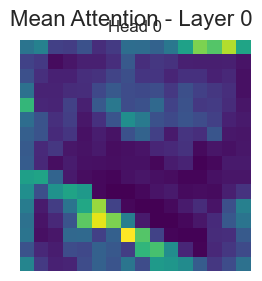

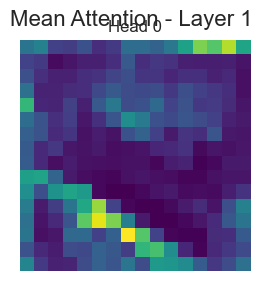

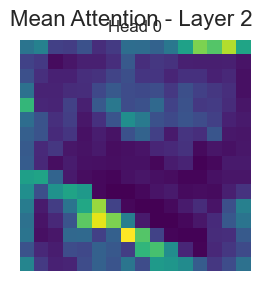

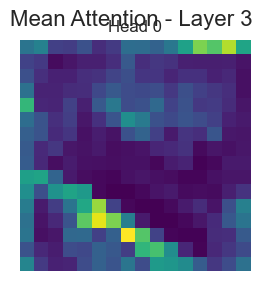

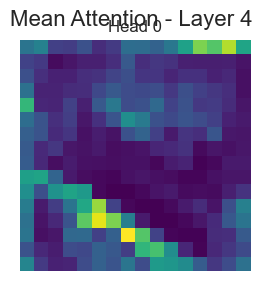

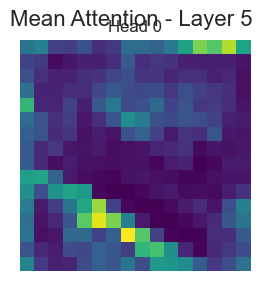

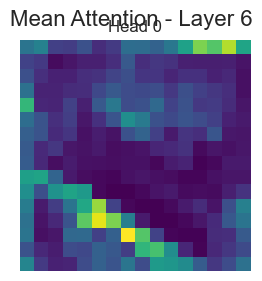

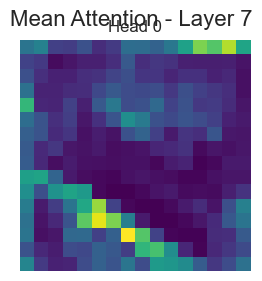

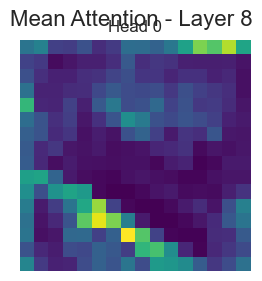

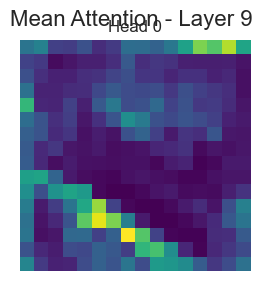

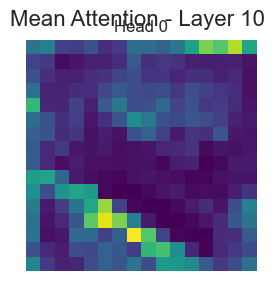

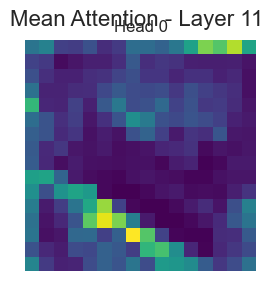

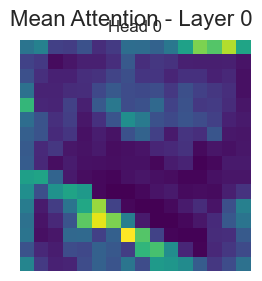

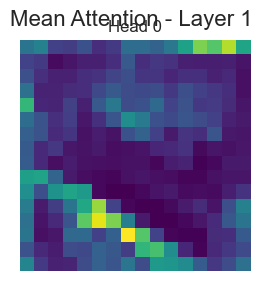

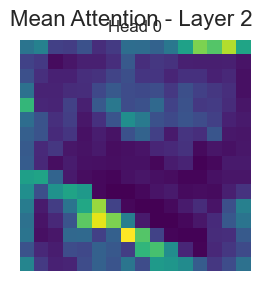

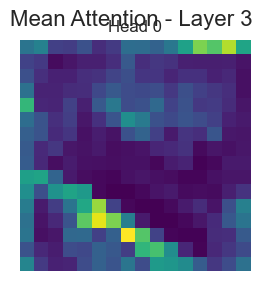

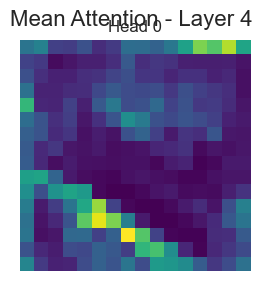

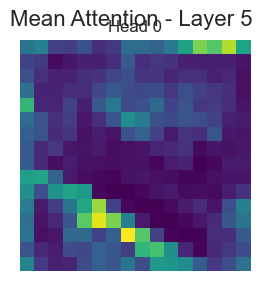

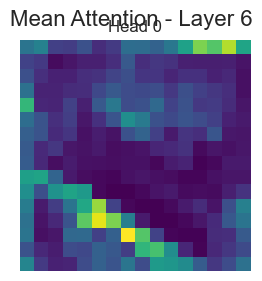

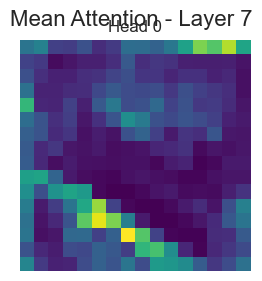

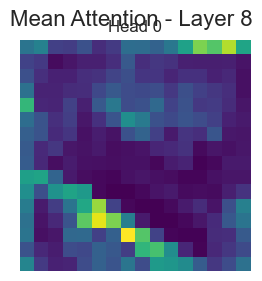

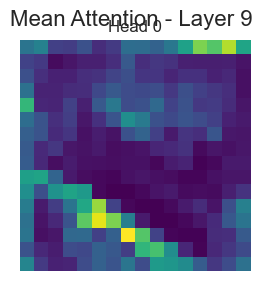

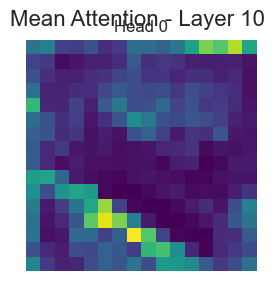

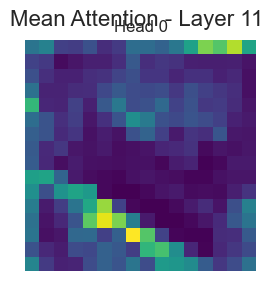

IndexError: Too many indices: 2-dimensional array indexed with 3 regular indices.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds
import cv2
import jax
from PIL import Image
import mediapy as mp
import tensorflow as tf
from octo.model.octo_model import OctoModel


### Load the BRIDGE Dataset
print("Loading BRIDGE dataset...")
builder = tfds.builder_from_directory(builder_dir="gs://gresearch/robotics/bridge/0.1.0/")
ds = builder.as_dataset(split="train[:1]")  # Load first episode

# Extract a single episode
episode = next(iter(ds))
steps = list(episode["steps"])
images = [cv2.resize(np.array(step["observation"]["image"]), (256, 256)) for step in steps]

# Extract goal image (last frame) & language instruction
goal_image = images[-1]
language_instruction = steps[0]["observation"]["natural_language_instruction"].numpy().decode()
print(f"Instruction: {language_instruction}")
mp.show_video(np.array(images), fps=10)  # Play the video of the episode


print("Loading Octo model checkpoint...")
model = OctoModel.load_pretrained("hf://rail-berkeley/octo-base-1.5")

observation = {
    "image_primary": goal_image[np.newaxis, np.newaxis, ...],  # Add batch + time dim
    "timestep_pad_mask": np.array([[True]])
}

task = model.create_tasks(texts=[language_instruction])


print("Running inference & extracting attention maps...")
_, attention_maps = model.sample_actions(observation, task, rng=jax.random.PRNGKey(0))

# Debug: Check attention map keys and structure
print(f"Available attention keys: {attention_maps.keys()}")
print(f"Number of layers: {len(attention_maps['mean'])}")
print(f"Attention shape per layer: {attention_maps['mean'][0].shape}")

def reshape_attention(attn_map):
    """Reshapes a 1D attention vector to a square matrix."""
    attn_map = attn_map.squeeze()  # Remove batch dimension if present
    new_size = int(np.sqrt(attn_map.shape[0]))  # Convert 256 → 16x16
    if new_size * new_size == attn_map.shape[0]:
        return attn_map.reshape((new_size, new_size))
    else:
        print(f"Warning: Cannot reshape {attn_map.shape} into a square.")
        return attn_map  # Return original if reshape isn't possible

# Apply before plotting
attention_map_reshaped = reshape_attention(attention_maps["mean"][0])


def plot_all_heads(attn_maps, layer_idx, title_prefix="Attention"):
    """
    Plots all attention heads for a given layer.

    Args:
        attn_maps: Attention tensor of shape (batch_size, num_heads, token_count)
        layer_idx: Transformer layer index
    """
    attn_maps = attn_maps[0]  # Take batch index 0
    num_heads = attn_maps.shape[0]

    fig, axes = plt.subplots(1, num_heads, figsize=(num_heads * 3, 3))
    fig.suptitle(f"{title_prefix} - Layer {layer_idx}", fontsize=16)

    for head in range(num_heads):
        ax = axes[head] if num_heads > 1 else axes
        reshaped_map = reshape_attention(attn_maps[head])  # Reshape if possible
        sns.heatmap(reshaped_map, ax=ax, cmap="viridis", square=True, cbar=False)
        ax.set_title(f"Head {head}")
        ax.axis("off")

    plt.show()


# Iterate over all layers and visualize all heads
for layer_idx in range(len(attention_maps["mean"])):
    plot_all_heads(attention_maps["mean"], layer_idx, title_prefix="Mean Attention")


# Iterate over all layers and visualize all heads
for layer_idx in range(len(attention_maps["mean"])):
    plot_all_heads(attention_maps["mean"], layer_idx, title_prefix="Mean Attention")


### Overlay Attention on Goal Image
def overlay_attention(img, attn_map):
    """Overlays an attention heatmap on an input image."""
    attn_map = cv2.resize(attn_map, (img.shape[1], img.shape[0]))  # Resize to match image
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())  # Normalize
    attn_heatmap = cv2.applyColorMap((attn_map * 255).astype(np.uint8), cv2.COLORMAP_JET)
    blended = cv2.addWeighted(np.array(img), 0.6, attn_heatmap, 0.4, 0)
    return blended


# Overlay attention from the first layer's first head
overlayed_image = overlay_attention(goal_image, attention_maps["mean"][0][0, :, :])

plt.imshow(overlayed_image)
plt.axis("off")
plt.title(f"Overlayed Attention - Layer 0, Head 0")
plt.show()


### Print Predicted Actions
print("\nSampled Actions:")
print(_[0])   # Shape: [batch, action_chunk, action_dim]


## Vision Encoder Visualization

Loading BRIDGE dataset...


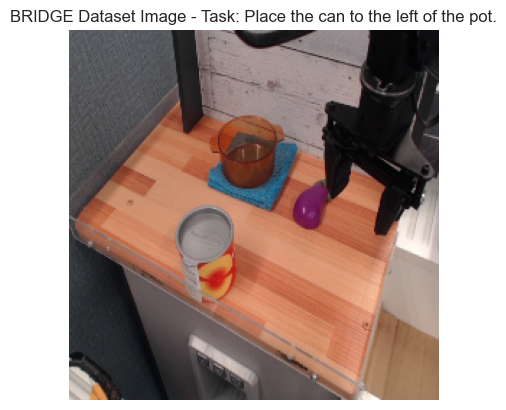

In [16]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load BRIDGE dataset
print("Loading BRIDGE dataset...")
builder = tfds.builder_from_directory(builder_dir="gs://gresearch/robotics/bridge/0.1.0/")
ds = builder.as_dataset(split="train[:1]")  # Load one episode

# Extract a sample episode
episode = next(iter(ds))
steps = list(episode["steps"])

# Extract the first frame image (modify for different frames)
image_raw = np.array(steps[0]["observation"]["image"])  # Shape: (H, W, 3)
language_instruction = steps[0]["observation"]["natural_language_instruction"].numpy().decode()

# Resize image to model input size (256x256)
image_resized = cv2.resize(image_raw, (256, 256))

# Normalize image for model input
sample_image = image_resized.astype(np.float32) / 255.0
sample_image = sample_image[np.newaxis, ...]  # Add batch dimension

# Display the image
plt.imshow(image_resized)
plt.axis("off")
plt.title(f"BRIDGE Dataset Image - Task: {language_instruction}")
plt.show()

In [20]:
import jax
from octo.model.octo_model import OctoModel

# Load the pretrained Octo model
model = OctoModel.load_pretrained("hf://rail-berkeley/octo-base-1.5")

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 5)